In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import time
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')


Length of text: 1115394 characters


In [4]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [5]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [6]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids


<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [7]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)


In [8]:
seq_length = 100


In [9]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))


tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [10]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)


for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [11]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text


In [12]:
dataset = sequences.map(split_input_target)


In [13]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())


Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [14]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [15]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [16]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.SimpleRNN(rnn_units,
                                         return_sequences=True,
                                         return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = [self.rnn.get_initial_state(x)]
    x, state = self.rnn(x, initial_state=states[0], training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, [state]
    else:
      return x

In [17]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)


In [18]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [19]:
model.summary()


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 simple_rnn (SimpleRNN)      multiple                  1311744   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 1,396,290
Trainable params: 1,396,290
Non-trainable params: 0
_________________________________________________________________


In [20]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()


In [21]:
sampled_indices


array([ 3, 55,  8, 31,  1, 47, 13, 61, 53, 21, 58, 26, 39, 35, 62, 29, 25,
       49, 47, 22, 16, 47, 53, 14, 17, 18, 30, 10, 18,  4,  7,  6, 12, 33,
       34,  8, 16, 50, 26, 57, 21, 19, 45, 58,  4, 57, 41, 28, 52, 59, 21,
        0, 28, 10, 18, 10, 13, 51,  6, 37, 61, 59, 26,  8, 12,  3, 40, 55,
       51, 57, 33, 11, 27, 26, 14, 52, 22, 33, 65, 46,  6,  0,  8, 35, 39,
       33, 37,  3, 50, 56, 25, 54, 22, 52, 65, 33, 55, 38, 34,  2])

In [22]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())


Input:
 b'rst Senator:\nSit, Coriolanus; never shame to hear\nWhat you have nobly done.\n\nCORIOLANUS:\nYour horror'

Next Char Predictions:
 b"!p-R\nh?vnHsMZVwPLjhIChnADEQ3E$,';TU-CkMrHFfs$rbOmtH[UNK]O3E3?l'XvtM-;!aplrT:NMAmITzg'[UNK]-VZTX!kqLoImzTpYU "


In [23]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


In [24]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)


Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.194723, shape=(), dtype=float32)


In [25]:
tf.exp(example_batch_mean_loss).numpy()


66.33536

In [26]:
model.compile(optimizer='adam', loss=loss)


In [27]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [28]:
EPOCHS = 30


In [29]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


Epoch 1/30
172/172 [==============================] - 31s 97ms/step - loss: 2.7726
Epoch 2/30
172/172 [==============================] - 25s 89ms/step - loss: 2.1187
Epoch 3/30
172/172 [==============================] - 25s 87ms/step - loss: 1.8925
Epoch 4/30
172/172 [==============================] - 26s 90ms/step - loss: 1.7462
Epoch 5/30
172/172 [==============================] - 26s 91ms/step - loss: 1.6467
Epoch 6/30
172/172 [==============================] - 26s 89ms/step - loss: 1.5760
Epoch 7/30
172/172 [==============================] - 26s 91ms/step - loss: 1.5253
Epoch 8/30
172/172 [==============================] - 26s 91ms/step - loss: 1.4822
Epoch 9/30
172/172 [==============================] - 26s 91ms/step - loss: 1.4522
Epoch 10/30
172/172 [==============================] - 26s 91ms/step - loss: 1.4253
Epoch 11/30
172/172 [==============================] - 26s 89ms/step - loss: 1.4015
Epoch 12/30
172/172 [==============================] - 26s 89ms/step - loss: 1.3818
E

In [30]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        if states is not None:
            states = [tf.identity(states[0])]  # Makes a copy of 'states'
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states



In [31]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [32]:
start = time.time()
states = None
next_char = tf.constant(['PEANUT:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)


PEANUT:
Ay, and thy foots the son of standent, as it is not stone to him, but yetress thee.

ProRINAUD:
Even to the realm crapp'd not of brother,
Traitor, thy son before love.

PAULINA:
I thank there was never be no walls,
Like intentest house: sir, alas!

GONZALO:
I was yourselves
To be the dark mastrius with wings I'll give my brother would
her in such an ounseloss as a late mine own king
I'll would out on.

First Servant:
Some spreticato's hither you will, thou shalt say some haste,
Or hurm her enesuel,
Which, as thou art a little:
There is no all, and a
lidaming the sudden stand his oaths!
Now, will you
Do well for him of plunt thy chamber. What?
by God's horse as much uneven of a suits,
Which too late why have I swalt consest.
And would even to him ne'er reign the litter will grieve your laphesed with thy loss,
Who would have vow'd bears very
Marry like on Rouse, marry; I know scoly shed bleeting York, to shame them
sound?

KING RICHARD II:
Sir Warwick will I:
You shall be thus gr

In [33]:
states

[<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[-0.96561956, -0.99994266,  0.9997311 , ...,  0.99998176,
         -0.99962515, -0.9594454 ]], dtype=float32)>]

In [35]:
history

In [36]:
print(history.history.keys())

dict_keys(['loss'])


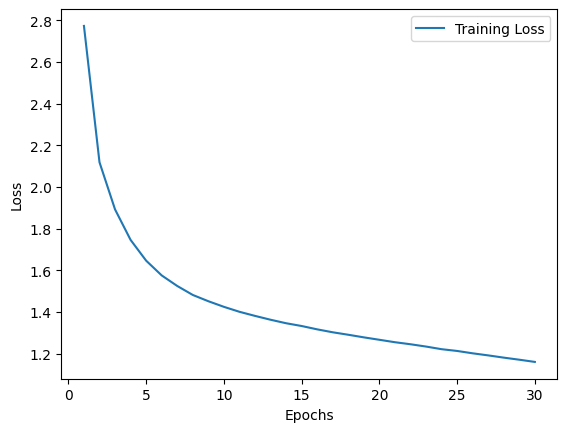

In [37]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
with open('losses_rnn.npy', 'wb') as f:
    np.save(f, loss_values)